# Pareto Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [5]:
data = pd.read_csv('/Users/sylvia/Desktop/datasets/googleplaystore.csv')
data.shape

(10841, 13)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Granularity of dataset is each row belongs to 1 mobile app.

In [6]:
data.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


### Pick 1 categorical column & 1 numerical column and then do Pareto Analysis.

- For Categorical analysis we pick any category column e.g. apps and then identify what are those imp apps, can be w.r.t size/reviews/installs as metric.
- Can pick category column & analyse which r those imp categories when it comes to mobile applications i.e. categories which poeple r interested in i.e. which contribute to most installs.
- Here we pick Category as categorical col & Installs as numeric column & then so Pareto Analysis.


### Installs column is object type (has + with it), inorder to perform aggregations/mathematical operations on installs columns we need to clean data i.e. change install columns to numeric.

Use regular expression to identify anything that is not a number & replace it with empty string i.e retain only numbers. In case empty string, replace by None.

In [8]:
data['installs_numeric'] = data['Installs'].apply(lambda v: re.sub('[^0-9]', '', v)).replace('', None).astype(float)

In [9]:
data.describe(include='object')

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
count,10841,10841,10841,10841,10841,10840,10841,10840,10841,10841,10833,10838
unique,9660,34,6002,462,22,3,93,6,120,1378,2832,33
top,ROBLOX,FAMILY,0,Varies with device,"1,000,000+",Free,0,Everyone,Tools,"August 3, 2018",Varies with device,4.1 and up
freq,9,1972,596,1695,1579,10039,10040,8714,842,326,1459,2451


## Which categories of apps are mostly installed?

To answer this question-

- Pick CAtegory as categorical column
- Pick Installs as numeric column/KPI

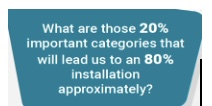

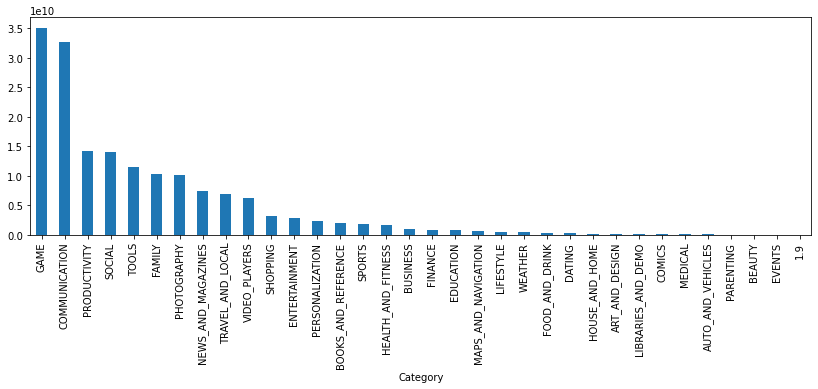

In [10]:
cats_inst = data.groupby('Category')['installs_numeric'].sum()
cats_inst.sort_values(ascending=False).plot.bar(figsize=(14,4));

In [11]:
cats_inst = data.groupby(['Category'])['installs_numeric'].sum()
cats_inst = cats_inst.sort_values(ascending=False)
cats_inst.head()

Category
GAME             3.508602e+10
COMMUNICATION    3.264728e+10
PRODUCTIVITY     1.417609e+10
SOCIAL           1.406987e+10
TOOLS            1.145277e+10
Name: installs_numeric, dtype: float64

### Find Cumulative sum on top of absolute numbers

In [12]:
cats_inst_cum = cats_inst.cumsum()
cats_inst_cum.head()

Category
GAME             3.508602e+10
COMMUNICATION    6.773330e+10
PRODUCTIVITY     8.190939e+10
SOCIAL           9.597926e+10
TOOLS            1.074320e+11
Name: installs_numeric, dtype: float64

### Find Cumulative percentage

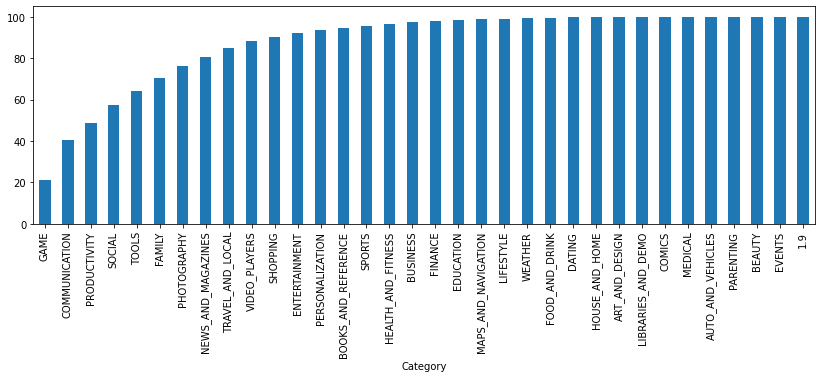

In [14]:
cats_inst_cum_perc = cats_inst.cumsum() / cats_inst.sum() * 100
cats_inst_cum_perc.plot.bar(figsize=(14,4));
#cats_inst_cum_perc.plot.line(figsize=(14,4), color='red')

### How many categories it takes to reach 80%?

With just 7 categories as shown below out of total of 34 categories we can reach 80% of installs.

In [14]:
imp_cats = cats_inst_cum_perc[cats_inst_cum_perc < 80]
imp_cats

Category
GAME             20.930194
COMMUNICATION    40.405580
PRODUCTIVITY     48.862176
SOCIAL           57.255406
TOOLS            64.087435
FAMILY           70.206893
PHOTOGRAPHY      76.224930
Name: installs_numeric, dtype: float64

### Calculate % of categories that give 80% of result.

In [15]:
len(imp_cats) / len(cats_inst_cum_perc) * 100

20.588235294117645

Remaining 80% categories only contribute to 20% results.

### Summary result custom function for Pareto Analysis

In [15]:
def pareto_results(data):
    data_cumsum = data.sort_values(ascending=False).cumsum() / data.sum()
    imp_cats = data_cumsum[data_cumsum < 0.8]
    summary_data = {
        'n_major_categories': len(imp_cats),
        'pareto_percentage': len(imp_cats) / len(data) * 100,
        'major_categories': imp_cats.index.tolist(),
        'n_total_categories': len(data), 
    }
    return summary_data

### Dual y-axis Chart for Pareto Analysis using twinx

In [18]:
def pareto_chart(data):
    data_cumsum = data.sort_values(ascending=False).cumsum() / data.sum() * 100
    fig, ax1 = plt.subplots(figsize=(10,4))

    ax2 = ax1.twinx()
    data_cumsum.head(200).plot.line(ax=ax2, color='red')
    data.sort_values(ascending=False).head(200).plot.bar(ax=ax1)

    ax1.set_xlabel(data.name)
    ax1.set_ylabel('Absolute numbers')
    ax2.set_ylabel('Cumulative Percentage')

### Input to Pareto Chart custom function is cats_inst which is groupby() Category based on installs numeric KPI

In [16]:
cats_inst   

Category
GAME                   3.508602e+10
COMMUNICATION          3.264728e+10
PRODUCTIVITY           1.417609e+10
SOCIAL                 1.406987e+10
TOOLS                  1.145277e+10
FAMILY                 1.025826e+10
PHOTOGRAPHY            1.008825e+10
NEWS_AND_MAGAZINES     7.496318e+09
TRAVEL_AND_LOCAL       6.868887e+09
VIDEO_PLAYERS          6.222003e+09
SHOPPING               3.247849e+09
ENTERTAINMENT          2.869160e+09
PERSONALIZATION        2.325495e+09
BOOKS_AND_REFERENCE    1.921470e+09
SPORTS                 1.751174e+09
HEALTH_AND_FITNESS     1.583073e+09
BUSINESS               1.001915e+09
FINANCE                8.766487e+08
EDUCATION              8.714520e+08
MAPS_AND_NAVIGATION    7.242819e+08
LIFESTYLE              5.376435e+08
WEATHER                4.261005e+08
FOOD_AND_DRINK         2.738988e+08
DATING                 2.643108e+08
HOUSE_AND_HOME         1.687125e+08
ART_AND_DESIGN         1.243381e+08
LIBRARIES_AND_DEMO     6.299591e+07
COMICS             

In [21]:
## Call function pareto_results

summary = pareto_results(cats_inst)
summary

{'n_major_categories': 7,
 'pareto_percentage': 20.588235294117645,
 'major_categories': ['GAME',
  'COMMUNICATION',
  'PRODUCTIVITY',
  'SOCIAL',
  'TOOLS',
  'FAMILY',
  'PHOTOGRAPHY'],
 'n_total_categories': 34}

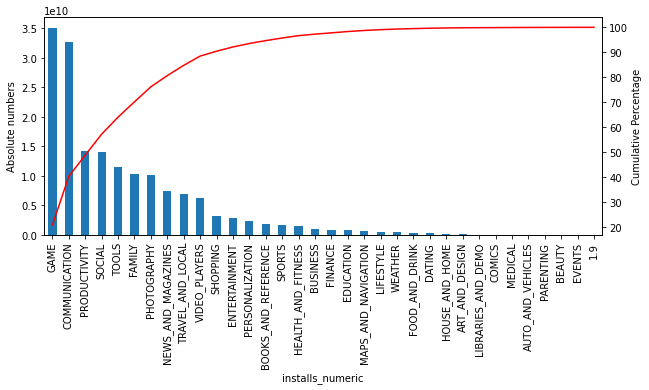

In [22]:
## Call function pareto_chart

pareto_chart(cats_inst)